<h1 align="center">Numerical Methods for</h1>
<h1 align="center">Heston Model in Option Pricing</h1>

<h3 align="center">YuHsuan Shih, ys2898  | Francis Chen, hc2857 </h3> 

## 1. Introduction

The Heston Model in Finance, named after Steven Heston [1], is a stochastic mathematical model, describing the evolution of volatility and price of an underlying asset, which extends the famous Black-Scholes model by allowing volatility to follow a mean reverting stochastic process. Heston model is commonly used in option pricing, especially for European option, which can only be exercised at the maturity. 

For better understanding, we'd like to introduce some basic logics about the financial derivative: option. "A call option gives the holder the right to buy the underlying asset
by a certain date for a certain price. A put option gives the holder the right to sell the underlying asset by a certain date for a certain price." [2]

The payoff of an European call and put option is given by:

$$
\text{Call Option Payoff } = (S_T - K)^+ \qquad \text{Put Option Payoff } = (K - S_T)^+
$$

The option price is the certain fee that the buyer should pay for entering the contract. Because the expected return of an option is always non-negative, by the fundamental theorem of asset pricing, the arbitrage-free condition must be satisfied. Simply speaking, no "free lunch" could exist in the market. Including the option price, the profit and loss curve is shown as follows [2]:

![Option P&L](./payoff.jpg)

Generally, we are interested in applying numerical methods to solve the Heston model and find the fair price of a given European option. 

### 1.1 Mathematical Model
In Heston Model, the stock price and volatility are assumed to follow two different stochastic processes [1]:

$$
\text{Stock Price: }\quad dS_t = \mu S_t\, dt + \sqrt{V_t}S\, dW^1_t
$$

$$
\text{Volatility: }\quad dV_t = \kappa(\theta - V_t)\, dt + \sigma\sqrt{V_t}\, dW^2_t
$$

where $W^1$ and $W^2$ are two correlated Wiener Processes(continuous Brownian Motion), with correlation $\rho$: $dW^1\, dW^2 = \rho\, dt$. 

By derivation (under risk-neutral measure), the stochastic model can be generated to a Partial Differential Equation for the function of option price $U(S,v,t)$ [3]:

$$
\frac{\partial U}{\partial t} = \frac 1 2 v S^2 \frac{\partial^2 U}{\partial S^2} + \rho\sigma v S \frac{\partial^2 U}{\partial U\partial v} + \frac 1 2 \sigma^2v\frac{\partial^2 U}{\partial v^2} + (r-q)S\frac{\partial U}{\partial S} + \kappa(\theta - v)\frac{\partial U}{\partial v} - rU
$$

where,
$$\begin{aligned}
&t: \text{time to maturity}\\
&v: \text{variance/volatility of the stock}\\
&S: \text{stock price}\\
&\rho : \text{correlation between two Brownian Motions}\\
&\sigma: \text{the volatility of v}\\
&r: \text{interest rate}\\
&q: \text{continuously compounded dividend rate}\\
&\kappa: \text{mean reverting rate of v}\\
&\theta: \text{long run mean of v}\\
&2\kappa\theta > \sigma^2: \text{to assure positive v}
\end{aligned}$$

For European call option, Heston PDE is subject to the following boundary conditions:

$$\begin{aligned}
U(S,v,0) &= (S-K)^+ \\
\lim_{S\rightarrow 0} \frac{\partial^2 U}{\partial S^2}(S,v,t) & = 0\\
\lim_{S\rightarrow\infty} \frac{\partial^2 U}{\partial S^2}(S,v,t) & = 0\\
(r-q)S\frac{\partial U}{\partial S} + \kappa\theta\frac{\partial U}{\partial v} - rU - \frac{\partial U}{\partial t} &= 0\\
\lim_{S\rightarrow\infty} U(S,v,t) & = S
\end{aligned}$$

where $K$ is the pre-determined strike price.

### 1.2 Closed form solution
Heson(1993) provided a closed form solution for this PDE in pricing European call option:

$$
C_t = S_te^{-q(T-t)} P_1 - Ke^{-r(T-t)}P_2
$$

where $C_t$ is the call option price at current time $t$, and $T$ is the pre-determined maturity. And for $j=1,2$:
$$
P_j = \frac 1 2 + \frac 1 \pi \int_0^{\infty} Re\left( \frac{e^{-i\phi\ln(K)} f_j}{i\phi}\right) d\phi \\
$$

$$
f_j = \exp \left( A_j+B_jv_t+i\phi\ln(S_t)\right)
$$

$$
A_j = r\phi i\tau + \frac{\kappa\theta}{\sigma^2}\left[ (b_j-\rho\sigma\phi i+d)\tau-2\ln\left( \frac{1-g_je^{dr}}{1-g_j}\right) \right]
$$

$$
B_j = \frac{b_j-\rho\sigma\phi i+d_j}{\sigma^2} \left(\frac{1-e^{d_j\tau}}{1-g_je^{d_j\tau}} \right) \\
$$

$$
g_j = \frac{b_j-\rho\sigma\phi i+d_j}{b_j-\rho\sigma\phi i-d_j}\\
$$

$$
d_j = \sqrt{( \rho\sigma\phi i-b_j)^2-\sigma^2(2\mu_j\phi i-\phi^2)}
$$

where,
$$
\tau=T-t,\ \ u_1 = \frac 1 2, \ \ u_2 = -\frac 1 2, \ \ b_1 = \kappa-\rho\sigma,\ \ b_2=\kappa
$$

Implementation of exact solution:

In [1]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

def Heston_Integral(phi, K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, j):
    
    u_1 = 0.5
    u_2 = - 0.5
    a = kappa * theta
    rspi = rho * sigma * phi * 1j
    tau = (T - t)
    
    b_1 = kappa + _lambda - rho * sigma
    b_2 = kappa + _lambda
    
    d_1 = numpy.sqrt((rspi - b_1)**2 - sigma**2 * (2.0 * u_1 * phi * 1j - phi**2))
    d_2 = numpy.sqrt((rspi - b_2)**2 - sigma**2 * (2.0 * u_2 * phi * 1j - phi**2))
    
    g_1 = (b_1 - rspi + d_1) / (b_1 - rspi - d_1)
    g_2 = (b_2 - rspi + d_2) / (b_2 - rspi - d_2)
   
    D_1 = (b_1 - rspi + d_1) / sigma**2 * ((1.0 - numpy.exp(d_1 * tau)) / (1.0 - g_1 * numpy.exp(d_1 * tau)))
    D_2 = (b_2 - rspi + d_2) / sigma**2 * ((1.0 - numpy.exp(d_2 * tau)) / (1.0 - g_2 * numpy.exp(d_2 * tau)))
    
    C_1 = r * phi * 1j * tau + a / sigma**2 * ((b_1 - rspi + d_1) * tau - 2.0 * numpy.log((1.0 - g_1 * numpy.exp(d_1 * tau))/(1.0 - g_1)))
    C_2 = r * phi * 1j * tau + a / sigma**2 * ((b_2 - rspi + d_2) * tau - 2.0 * numpy.log((1.0 - g_2 * numpy.exp(d_2 * tau))/(1.0 - g_2)))   
    
    if(S > 0):
        f_1 = numpy.exp(C_1 + D_1 * v + 1j * phi * numpy.log(S))
        f_2 = numpy.exp(C_2 + D_2 * v + 1j * phi * numpy.log(S))
    
    if(j==1):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_1)/(1j * phi))
    elif(j==2):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_2)/(1j * phi))

# The closed-form solution for Heston PDE
from scipy.integrate import quad
def Heston_ExactSolution(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda):
    
    P_1 = 0.5 + 1.0 / numpy.pi * quad(Heston_Integral, 0, 1000, args=(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, 1))[0]
    P_2 = 0.5 + 1.0 / numpy.pi * quad(Heston_Integral, 0, 1000, args=(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, 2))[0]
    
    Call = S * P_1 - K * numpy.exp(- r * (T - t)) * P_2
    return Call

In [24]:
# Test
K = 100.0
S = 100.0
V = 0.04
T = 0.25
t = 0.0
r = 0.03
kappa = 2.0
theta = 0.20
sigma = 0.3
rho = -0.5
_lambda = 0.02
print "Test call option price: ",Heston_ExactSolution(K, S, V, T, t, r, kappa, theta, sigma, rho, _lambda)

Test call option price:  5.74042230856


Solution Surface Plot:

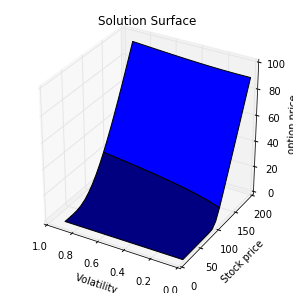

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

K = 100.0
T = 0.50
t = 0.0
r = 0.025
kappa = 2.0
theta = 0.04
sigma = 0.3
rho = -0.5
_lambda = 0.00

fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')
v = np.arange(0, 1.0, 0.1)
s = np.arange(10, 200, 10)
V, S = np.meshgrid(v, s)

z = np.array([Heston_ExactSolution(K, s, v, T, t, r, kappa, theta, sigma, rho, _lambda) for v, s in zip(np.ravel(V), np.ravel(S))])
Z = z.reshape(V.shape)

ax.plot_surface(V, S, Z)
ax.set_zlim(0, 100)
ax.set_xlim(1.0, 0.0)
ax.set_ylim(0, 200)
ax.set_title("Solution Surface")
ax.set_xlabel("Volatility")
ax.set_ylabel("Stock price")
ax.set_zlabel("Option price")
plt.show()

## 2. Numerical Methods

### 2.1 Explicit Scheme

### 2.2 Implicit Scheme

### 2.3 Alternative Direction Implicit

### 2.4 Monte Carlo Simulation
Monte Carlo Simulation is a broadly used class of computational algorithms that rely on repeated random sampling to obtain numerical results. 

Since the stochastic factors in Heston model are assumed to follow two correlated continuous Brownian Motions, we could generate random path to simulate the stock price evolution. Mathematically, the Brownian Motion has independent and stationary Gaussian increments:

$$
B_t \sim N(0,t),\qquad  E(B_t) = 0,\qquad Var(B_t) = t
$$

which is equiavalent to a normal random variable:

$$
B_{t+\Delta t} - B_t \sim \Delta t Z, \qquad Z\sim N(0,1)
$$

In addition, the correlation of two Brownian Motions can be re-written as:
$$
dW^2_t = \rho dW^1_t + \sqrt{1-\rho^2}\Delta t \cdot Z
$$

Therefore, the simulation method can be mathematically shown as:

$$
S_{t+1} = rS_t\cdot\Delta t + \sqrt{V_t}S_t\cdot\Delta t\cdot Z_1
$$

$$
V_{t+1} = \kappa(\theta - V_t)\cdot\Delta t + \sigma\sqrt{V_t}\cdot \Delta t\cdot Z_2
$$

$$
Z_2 = \rho Z_1 + \sqrt{1-\rho^2}Z
$$

In practice, we simulate $M$ paths of stock price. The call option price for each path at maturity is just $(S_T-K)^+$. Then we compute the average of those simulated values and discount the mean price as the current option price. 

Implementation of Monte Carlo Method:

In [14]:
# Monte Carlo Simulation
import numpy.random as rnd
def Heston_MonteCarlo(M, K, S0, V0, T, t, r, kappa, theta, sigma, rho, _lambda):
    N = int(numpy.round(252 * (T - t))) + 1 #time steps are evaluated per day
    dt = (T - t) / float(N)
    Sqrtdt = numpy.sqrt(dt)
    
    _k = kappa + _lambda
    _theta = (kappa * theta) / (kappa + _lambda)
    S = numpy.zeros((M, N + 1))
    S[:,0] = S[:,0] + S0
    V = numpy.zeros((M, N + 1))
    V[:,0] = V[:,0] + V0
    Call_vals = numpy.empty(M)
    for i in xrange(M):
        for j in xrange(N):
            dW1 = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
            dZ = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
            S[i,j+1] = S[i,j] + r * S[i,j] * dt + numpy.sqrt(abs(V[i,j])) * S[i,j] * dW1
            dW2 = rho * dW1 + numpy.sqrt(1.0 - rho**2) * dZ
            V[i,j+1] = V[i,j] + _k * (_theta - V[i,j]) * dt + sigma * numpy.sqrt(abs(V[i,j])) * dW2

        Call_vals[i] = max(S[i,-1] - K, 0.0) * numpy.exp(- r * (T - t))
            
    Call = numpy.mean(Call_vals)
    return Call

In [21]:
# Test Monte Carlo
M = 5000
K = 100.0
S = 100.0
V = 0.05
T = 0.25
t = 0.0
r = 0.03
kappa = 2.0
theta = 0.20
sigma = 0.3
rho = -0.5
_lambda = 0.05
MC = Heston_MonteCarlo(M, K, S, V, T, t, r, kappa, theta, sigma, rho, _lambda)
true = Heston_ExactSolution(K, S, V, T, t, r, kappa, theta, sigma, rho, _lambda) 
print "Monte Carlo: ", MC
print "Exact solution: ", true

Monte Carlo:  5.99049857488
Exact solution:  6.00982376858


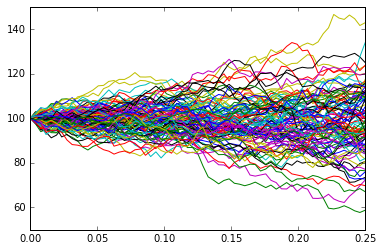

In [22]:
# Sample paths plot
M = 100
S0 = 100.0
V0 = 0.05
N = int(numpy.round(252 * (T - t))) + 1
dt = (T - t) / float(N)
Sqrtdt = numpy.sqrt(dt)
_k = kappa + _lambda
_theta = (kappa * theta) / (kappa + _lambda)
S = numpy.zeros((M, N + 1))
S[:,0] = S[:,0] + S0
V = numpy.zeros((M, N + 1))
V[:,0] = V[:,0] + V0
Call_vals = numpy.empty(M)
for i in xrange(M):
    for j in xrange(N):
        dB = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
        dW = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
        S[i,j+1] = S[i,j] + r * S[i,j] * dt + numpy.sqrt(abs(V[i,j])) * S[i,j] * dB
        dZ = rho * dB + numpy.sqrt(1.0 - rho**2) * dW
        V[i,j+1] = V[i,j] + _k*(_theta - V[i,j])*dt + sigma*numpy.sqrt(abs(V[i,j])) * dZ

x = numpy.linspace(t, T, N+1)
for i in xrange(M):
    plt.plot(x, S[i,:])
plt.show()

## 3. Error Analysis

## 4. Conclusion

## References
[1] Heston, S. L. (1993). A closed-form solution for options with stochastic volatility with applications to bond and currency options. Review of financial studies, 6(2), 327-343.

[2] Hull, J. C. (2015). Options, futures, and other derivatives. Pearson Education Inc.

[3] Hirsa, A. (2012). Computational methods in finance. Crc Press.